* In this assignment you will be building the **Encoder** part of the Transformer architecture.
* You will be using the **PyTorch** framework to implement the following components
  * Encoder Layer that contains
    * Multi-Head Attention (MHA) Module
    * Position-wise Feed Forward Neural Network

  * Output layer that takes the encoder output and predicts the token_ids.

  * Optionally, study whether adding positional information is helpful.
  
* **DO NOT** USE Built-in **TRANSFORMER LAYERS** as it affects the reproducibility.

* You will be given with a configuration file that contains information on various hyperparameters such as embedding dimension, vocabulary size,number heads and so on

* Use ReLU activation function and Stochastic Gradient Descent optimizer
* Here are a list of helpful Pytorch functions (does not mean you have to use all of them) for this and subsequent assignments
  * [torch.matmul](https://pytorch.org/docs/stable/generated/torch.matmul.html#torch-matmul)
  * [torch.bmm](https://pytorch.org/docs/stable/generated/torch.bmm.html)
  * torch.swapdims
  * torch.unsqueeze
  * torch.squeeze
  * torch.argmax
  * [torch.Tensor.view](https://pytorch.org/docs/stable/generated/torch.Tensor.view.html)
  * [torch.nn.Embedding](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html)
  * [torch.nn.Parameter](https://pytorch.org/docs/stable/generated/torch.nn.parameter.Parameter.html)
  * torch.nn.Linear
  * torch.nn.LayerNorm
  * torch.nn.ModuleList
  * torch.nn.Sequential
  * [torch.nn.CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)
  
* Important: **Do not** set any global seeds.

* Helpful resources to get started with

 * [Annotated Transformers](https://nlp.seas.harvard.edu/annotated-transformer/)
 * [PyTorch Source code of Transformer Layer](https://pytorch.org/docs/stable/generated/torch.nn.Transformer.html)



# Import

In [242]:
import torch
from torch import Tensor

import torch.nn as nn
from torch.nn import Parameter
import torch.nn.functional as F
from torch.nn.functional import one_hot

import torch.optim as optim

from  pprint import pprint
from yaml import safe_load
import requests
from io import BytesIO

# Configuration

In [243]:
#do not edit this cell
config_url = "https://raw.githubusercontent.com/Arunprakash-A/LLM-from-scratch-PyTorch/main/config_files/enc_config.yml"
response = requests.get(config_url)
config = response.content.decode("utf-8")
config = safe_load(config)
pprint(config)

{'input': {'batch_size': 10, 'embed_dim': 32, 'seq_len': 8, 'vocab_size': 10},
 'model': {'d_ff': 128,
           'd_model': 32,
           'dk': 4,
           'dq': 4,
           'dv': 4,
           'n_heads': 8,
           'n_layers': 6}}


In [244]:
#do not edit this cell
vocab_size = config['input']['vocab_size']
batch_size = config['input']['batch_size']
seq_len = config['input']['seq_len']
embed_dim = config['input']['embed_dim']

* Here, you are directly given with the token ids
* Assume that length of all sequences are equal to the context length (T) (so that we do not need to bother about padding shorter sequences while batching)

In [245]:
# do not edit this cell
data_url = 'https://github.com/Arunprakash-A/LLM-from-scratch-PyTorch/raw/main/config_files/w1_input_tokens'
r = requests.get(data_url)
token_ids = torch.load(BytesIO(r.content))
print(token_ids)

tensor([[5, 7, 5, 6, 3, 8, 7, 5],
        [7, 2, 7, 1, 2, 1, 1, 7],
        [1, 0, 0, 3, 6, 3, 0, 8],
        [5, 0, 2, 8, 6, 5, 5, 3],
        [3, 5, 4, 8, 5, 0, 7, 3],
        [8, 6, 7, 4, 4, 4, 0, 1],
        [5, 8, 1, 0, 1, 1, 0, 3],
        [1, 7, 8, 8, 0, 5, 3, 7],
        [7, 7, 1, 4, 5, 6, 7, 0],
        [1, 7, 2, 8, 3, 0, 0, 4]])


# Building the sub-layers

In [246]:
# do not edit this cell
dq = torch.tensor(config['model']['dq'])
dk = torch.tensor(config['model']['dk'])
dv = torch.tensor(config['model']['dv'])
dmodel = embed_dim
heads = torch.tensor(config['model']['n_heads'])
d_ff = config['model']['d_ff']

##Multi-Head Attention

 * Be mindful when using `torch.matmul`
 * Ensure that you understood what is being computed (because matrix product is not commutative)
 * Randomly initialize the parameters using normal distribution with the following seed values
  * $W_Q:$(seed=43)
  * $W_K:$(seed=44)
  * $W_V:$(seed=45)
  * $W_O:$(seed=46)

In [247]:
b=True
class MHA(nn.Module):

  def __init__(self,dmodel,dq,dk,dv,heads):
    super(MHA,self).__init__()
    # your code goes here
    self.dmodel = dmodel
    self.dq = dq
    self.dk = dk
    self.dv = dv
    self.heads = heads


    # init QKV and O
    self.W_q = nn.Linear(dmodel, dq * heads, bias=b)
    self.W_k = nn.Linear(dmodel, dk * heads, bias=b)
    self.W_v = nn.Linear(dmodel, dv * heads, bias=b)
    self.W_o = nn.Linear(dv * heads, dmodel, bias=b)




    torch.manual_seed(43)
    nn.init.normal_(self.W_q.weight)
    if b:
        nn.init.normal_(self.W_q.bias)

    torch.manual_seed(44)
    nn.init.normal_(self.W_k.weight)
    if b:
        nn.init.normal_(self.W_k.bias)

    torch.manual_seed(45)
    nn.init.normal_(self.W_v.weight)
    if b:
        nn.init.normal_(self.W_v.bias)

    torch.manual_seed(46)
    nn.init.normal_(self.W_o.weight)
    if b:
        nn.init.normal_(self.W_o.bias)

  # your method definitions go here (if you want to)

  def forward(self,H=None):
    '''
    Input: Size [BSxTxdmodel]
    Output: Size[BSxTxdmodel]
    '''
    # your code goes here

    # print(H.shape,'mha input')

    BS, T, _ = H.size()

    # H *  Q, K, V
    Q = self.W_q(H)
    K = self.W_k(H)
    V = self.W_v(H)

    # print(V.shape,'qkv shape')


    # multiple heads
    Q = Q.view(BS, T, self.heads, self.dq).transpose(1, 2)
    K = K.view(BS, T, self.heads, self.dk).transpose(1, 2)
    V = V.view(BS, T, self.heads, self.dv).transpose(1, 2)
    # print(V.shape,'multi head qkv shape')


    #  attention
    scores = torch.matmul(Q, K.transpose(-2,-1)) / (self.dk ** 0.5)
    # print(scores.shape,'scores shape')
    attn_weights = F.softmax(scores, dim=-1)
    # print(attn_weights.shape,'attention weights')
    context = torch.matmul(attn_weights, V)
    # print(context.shape,'context shape')

    # concat
    context = context.transpose(1, 2).contiguous().view(BS, T, self.dv*self.heads)

    # output
    out = self.W_o(context)
    return out

## Pointwise FFN

* Randomly initialize the parameters using normal distribution with the following seed values
  * $W_{1}:$(seed=47)
  * $W_2:$(seed=48)  

In [248]:
class FFN(nn.Module):
  def __init__(self,dmodel,d_ff,layer=0):
    super(FFN,self).__init__()
    #your code goes here
    #layers
    self.fc1 = nn.Linear(dmodel, d_ff, bias=b)
    self.fc2 = nn.Linear(d_ff, dmodel, bias=b)

    # init
    torch.manual_seed(47)
    nn.init.normal_(self.fc1.weight)
    if b:
        nn.init.normal_(self.fc1.bias)

    torch.manual_seed(48)
    nn.init.normal_(self.fc2.weight)
    if b:
        nn.init.normal_(self.fc2.bias)


  def forward(self,x):
    '''
    input: size [BSxTxdmodel]
    output: size [BSxTxdmodel]
    '''
    #your code goes here
    out = self.fc1(x)
    out = F.relu(out)
    out = self.fc2(out)
    return out

## Output Layer

* Randomly initialize the linear layer
 * $W_L:$(seed=49)


In [249]:
class OutputLayer(nn.Module):

  def __init__(self,dmodel,vocab_size):
    super(OutputLayer,self).__init__()
    # your code goes here

    self.proj = nn.Linear(dmodel, vocab_size,bias=b)



    torch.manual_seed(49)
    nn.init.normal_(self.proj.weight)
    if b:
      nn.init.normal_(self.proj.bias)


  def forward(self,representations):
    '''
    input: size [bsxTxdmodel]
    output: size [bsxTxvocab_size]
    Note: Do not apply the softmax. Just return the output of linear transformation
    '''
    out = self.proj(representations)
    return out

## Encoder Layer

In [250]:
class EncoderLayer(nn.Module):

  def __init__(self,dmodel,dq,dk,dv,d_ff,heads):
    super(EncoderLayer,self).__init__()
    self.mha = MHA(dmodel,dq,dk,dv,heads)
    self.layer_norm_mha = torch.nn.LayerNorm(dmodel)
    self.layer_norm_ffn = torch.nn.LayerNorm(dmodel)
    self.ffn = FFN(dmodel,d_ff)

  def forward(self,x):


    # print(x.shape,'encoder input')
    attn_out = self.mha(x)
    # print('mha output created')


    x = self.layer_norm_mha(x + attn_out)
    ffn_out = self.ffn(x)
    out = self.layer_norm_ffn(x + ffn_out)


    return out

## Model with one encoder layer

 * The encoders' forward function accepts the token_ids as input
 * Generate the embeddings for the token ids by initializing the emebedding weights from normal distribution by setting the seed value to 50
 * Use `torch.nn.Embed()` to generate required embeddings

In [251]:
class Encoder(nn.Module):

  def __init__(self,vocab_size,embed_dim,dq,dk,dv,d_ff,heads):
    super(Encoder,self).__init__()
    # your code goes here


    self.embedding = nn.Embedding(vocab_size, embed_dim)
    torch.manual_seed(50)
    nn.init.normal_(self.embedding.weight)

    # encoder block
    self.layer = EncoderLayer(embed_dim, dq, dk, dv, d_ff, heads)

    # outout layer
    self.output_layer = OutputLayer(embed_dim, vocab_size)


  def forward(self,x):
    print(x.shape,'token_ids')
    '''
    The input should be tokens ids of size [BS,T]
    '''
    # create embeddings
    out = self.embedding(x)

    print(out.shape,'embeddings')

    # forward pass
    out = self.layer(out)

    # output
    out = self.output_layer(out)

    return out

In [252]:
model = Encoder(vocab_size,dmodel,dq,dk,dv,d_ff,heads)
optimizer = optim.SGD(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

# Training the model

 * Train the model for 30 epochs and compute the loss

In [253]:
import sys
import os
import contextlib

def train(token_ids,epochs=None):
  global final_loss
  for epoch in range(epochs):

    with open(os.devnull, 'w') as f, contextlib.redirect_stdout(f):
        print(token_ids.shape,'input to model')
        out = model(token_ids)


        print(out.shape)
    loss = F.cross_entropy(out.view(-1, out.size(-1)), token_ids.view(-1))
    # print(loss,'loss')
    final_loss=float(loss)
    loss.backward()



    optimizer.step()
    optimizer.zero_grad()

pprint(config)
train(token_ids,30)

{'input': {'batch_size': 10, 'embed_dim': 32, 'seq_len': 8, 'vocab_size': 10},
 'model': {'d_ff': 128,
           'd_model': 32,
           'dk': 4,
           'dq': 4,
           'dv': 4,
           'n_heads': 8,
           'n_layers': 6}}


# Inference

In [254]:
with torch.inference_mode():
  predictions =  model(token_ids).argmax(dim=-1)


out = model(token_ids)
print(out.view(-1, out.size(-1))[0],)

torch.Size([10, 8]) token_ids
torch.Size([10, 8, 32]) embeddings
torch.Size([10, 8]) token_ids
torch.Size([10, 8, 32]) embeddings
tensor([-2.5171,  5.6252, -7.6966,  0.5701,  5.1249, -2.4318, -5.3007,  0.4060,
         0.3233, -5.3537], grad_fn=<SelectBackward0>)


* See how many labels are correctly predicted

In [255]:
print(torch.count_nonzero(token_ids==predictions))

tensor(41)


* The loss by now should be about 2.39 and the number of correct predictions should be about 37

In [256]:
print('Loss :' +str(final_loss) + ' |','Correct predictions :'+str(int(torch.count_nonzero(token_ids==predictions))))

Loss :2.373548746109009 | Correct predictions :41


# Encoder with N Layers

  * The intialized parameters in all layers are identical
  * use ModuleList to create **deep-copies** of encoder layer

In [257]:
import copy

In [258]:
class Encoder(nn.Module):

  def __init__(self,vocab_size,dmodel,dq,dk,dv,d_ff,heads,num_layers=2):
    super(Encoder,self).__init__()
    self.embed_weights = nn.Embedding(vocab_size, embed_dim)
    self.enc_layers = nn.ModuleList([
        EncoderLayer(embed_dim, dq, dk, dv, d_ff, heads)
        for _ in range(num_layers)
    ])
    self.output_layer = OutputLayer(embed_dim, vocab_size)

  def get_embeddings(self, x):
      return self.embed_weights(x)

  def forward(self,x):
    '''
    1. Get embeddings
    2. Pass it through encoder layer-1 and recursively pass the output to subsequent enc.layers
    3. output the logits
    '''

    out = self.embed_weights(x)


    for layer in self.enc_layers:
        out = layer(out)

    out = self.output_layer(out)
    return out



* Train the stack of encoder layers with `num_layers=2` for the same 30 epochs

In [259]:
model = Encoder(vocab_size,dmodel,dq,dk,dv,d_ff,heads,num_layers=2)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [260]:

def train(token_ids,epochs=None):
  global final_loss
  for epoch in range(epochs):

    with open(os.devnull, 'w') as f, contextlib.redirect_stdout(f):
      out = model(token_ids)


    loss = F.cross_entropy(out.view(-1, out.size(-1)), token_ids.view(-1))
    # print(loss,'loss')
    final_loss = float(loss)
    loss.backward()


    optimizer.step()
    optimizer.zero_grad()


In [261]:
train(token_ids,30)

In [262]:
with torch.inference_mode():
  predictions = model(token_ids).argmax(dim=-1)

In [263]:
torch.count_nonzero(predictions==token_ids)

tensor(42)

* Now, the loss value should be about 1.9 and the number of correct preditions is about 38

In [264]:
# print(final_loss,torch.count_nonzero(predictions==token_ids) )

print('Loss :' +str(final_loss) + ' |','correct predictions :'+str(int(torch.count_nonzero(token_ids==predictions))))

Loss :1.8404735326766968 | correct predictions :42


## Count Number of Parameters

In [265]:
total_num_parameters=0
for parameter in model.parameters():
  total_num_parameters += parameter.numel()

print('total number of parameters in the model \n including the embedding layer is:', total_num_parameters)

total number of parameters in the model 
 including the embedding layer is: 26058


## (Optional) Positional Encoding

 * We now use the positional embedding as defined in the [paper](https://arxiv.org/pdf/1706.03762v1.pdf) (differs a bit from the lecture).
 * Note that, the positional encoding for each position is fixed (not a learnable parameter)
 * However, we add this with the raw_embeddings which are learnable.
 * Therefore, it is important to create a class definition for PE and register PE parameters in the buffer (in case we move the model to GPU)
 * Just create a matrix of same size of input and add it to the embeddings

In [266]:
import math
class PositionalEncoding(nn.Module):
    "Implement the PE function."

    def __init__(self,d_model,max_len=8):
        super(PositionalEncoding, self).__init__()


        pe = torch.zeros(max_len, d_model)

        pos = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)

        # print(pos)


        i = torch.arange(0, d_model // 2, dtype=torch.float)

        # print(i)

        div_term = torch.pow(math.log(10000.0), (2 * i) / d_model)

        # print(div_term)

        angle_rates = pos / div_term

        print(pe.shape)


        pe[:, 0::2] = torch.sin(pos / div_term)  # even dims
        pe[:, 1::2] = torch.cos(pos / div_term)  # odd dims

        # print(pe.shape)

        pe = pe.unsqueeze(0)
        print(pe.shape)

        self.register_buffer('pe', pe)


    def forward(self, x):


        seq_len = x.size(1)
        x = x + self.pe[:, :seq_len, :]
        return x


In [267]:
embeddings = model.get_embeddings(token_ids)


In [268]:
embeddings.shape

torch.Size([10, 8, 32])

In [269]:
pe = PositionalEncoding(32)

pe(embeddings).shape

torch.Size([8, 32])
torch.Size([1, 8, 32])


torch.Size([10, 8, 32])

# Visualize no encode vs  pos encoded

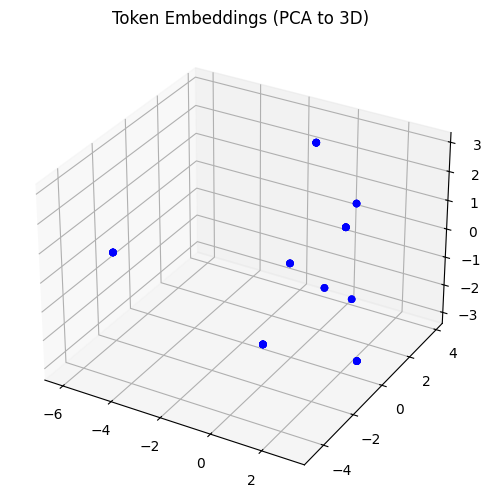

In [270]:
flat_embeddings = embeddings.view(-1, 32)

from sklearn.decomposition import PCA

pca = PCA(n_components=3)

embeddings_3d = pca.fit_transform(flat_embeddings.detach().cpu().numpy())

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
x, y, z = embeddings_3d[:, 0], embeddings_3d[:, 1], embeddings_3d[:, 2]
ax.scatter(x, y, z, c='blue', marker='o')

ax.set_title('Token Embeddings (PCA to 3D)')
plt.show()


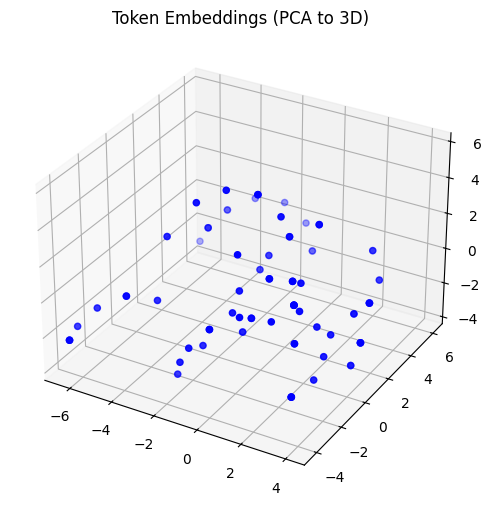

In [271]:
flat_embeddings = pe(embeddings).view(-1, 32)

from sklearn.decomposition import PCA

pca = PCA(n_components=3)

embeddings_3d = pca.fit_transform(flat_embeddings.detach().cpu().numpy())

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
x, y, z = embeddings_3d[:, 0], embeddings_3d[:, 1], embeddings_3d[:, 2]
ax.scatter(x, y, z, c='blue', marker='o')
ax.set_title('Token Embeddings (PCA to 3D)')
plt.show()
